In [1]:
# default_exp distance_zonal_stats

In [2]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq git+https://github.com/thinkingmachines/geowrangler.git

In [3]:
# hide
# no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [4]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson files from repo

In [5]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
# hide
import warnings

from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings(action="ignore", category=UserWarning, module="geopandas")
warnings.filterwarnings(
    action="ignore", category=ShapelyDeprecationWarning, module="pandas"
)

# Distance Zonal Stats

> generate vector zonal stat features for distances to features

In [7]:
# export
from typing import Any, Dict, List

import geopandas as gpd

import geowrangler.area_zonal_stats as azs
import geowrangler.vector_zonal_stats as vzs
from geowrangler.vector_zonal_stats import GEO_INDEX_NAME

In [8]:
# hide
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

In [9]:
# exporti
INTERNAL_DISTANCE_COL = "__Geowrangleer_nearest_distance"


def build_agg_distance_dicts(expanded_aggs, distance_col):
    agg_dicts = vzs._build_agg_args(expanded_aggs)
    if distance_col is not None:
        agg_dicts[distance_col] = (INTERNAL_DISTANCE_COL, "mean")
    return agg_dicts

In [10]:
# export
def create_distance_zonal_stats(
    aoi: gpd.GeoDataFrame,  # Area of interest for which zonal stats are to be computed for
    data: gpd.GeoDataFrame,  # Source gdf of region/areas containing data to compute zonal stats from
    max_distance: float,  # max distance to compute distance for (the larger the slower the join), set to None for no limit
    aggregations: List[Dict[str, Any]],  # aggregations
    distance_col: str = "nearest",  # column name of the distance column, set to None if not wanted in results
):
    """Computes zonal stats based on nearest matching data geometry within `max_distance`.
    Note that setting a too high max_distance (or None) will incur a performance cost.
    """
    # aoi/data crs should be planar
    azs.validate_area_aoi(aoi)
    azs.validate_area_data(data)

    fixed_aggs = [vzs._fix_agg(agg) for agg in aggregations]

    vzs._validate_aggs(fixed_aggs, data)

    # reindex aoi
    aoi_index_name = aoi.index.name
    aoi = vzs._prep_aoi(aoi)

    # sync aoi/data crs
    if not data.crs.equals(aoi.crs):
        data = data.to_crs(aoi.crs)

    # add spatial indexes
    aoi.geometry.sindex
    data.geometry.sindex

    # nearest
    nearest = gpd.sjoin_nearest(
        aoi[[GEO_INDEX_NAME, "geometry"]],
        data,
        how="inner",
        max_distance=max_distance,
        distance_col=INTERNAL_DISTANCE_COL,
    )

    groups = nearest.groupby(GEO_INDEX_NAME)

    expanded_aggs = vzs._expand_aggs(fixed_aggs)
    agg_distance_dicts = build_agg_distance_dicts(expanded_aggs, distance_col)

    aggregates = groups.agg(**agg_distance_dicts)

    results = aoi.merge(
        aggregates, how="left", on=GEO_INDEX_NAME, suffixes=(None, "_y")
    )
    vzs._fillnas(expanded_aggs, results, aoi)

    results.set_index(GEO_INDEX_NAME, inplace=True)
    results.index.name = aoi_index_name
    return results

## Test data

### Simple squares

In [11]:
def make_point_df(
    xsize,
    ysize,
    has_internet=True,
    has_population=True,
    size=1,
    offset_x=0.25,
    offset_y=0.0,
    pop_x_factor=100,
    pop_y_factor=0,
    internet_base_speed=20.0,
    internet_x_exp=2.0,
    internet_y_factor=100,
    crs="EPSG:3857",
):
    d = dict(
        geometry=[
            Point(x + offset_x, y + offset_y)
            for x in range(xsize)
            for y in range(ysize)
        ]
    )
    if has_population:
        d["population"] = [
            pop_x_factor * (x + 1) + y * (pop_x_factor * ysize + pop_y_factor)
            for x in range(xsize)
            for y in range(ysize)
        ]
    if has_internet:
        d["internet_speed"] = [
            internet_base_speed / (internet_x_exp**x) + internet_y_factor * y
            for x in range(xsize)
            for y in range(ysize)
        ]
    return gpd.GeoDataFrame(d, crs=crs)

In [12]:
# hide
def square(x, y, size=1):
    return Polygon([(x, y), (x, size + y), (size + x, size + y), (size + x, y)])

In [13]:
# hide
def make_df(
    xsize,
    ysize,
    has_internet=True,
    has_population=True,
    size=1,
    offset_x=0.25,
    offset_y=0.0,
    pop_x_factor=100,
    pop_y_factor=0,
    internet_base_speed=20.0,
    internet_x_exp=2.0,
    internet_y_factor=100,
    crs="EPSG:3857",
):
    d = dict(
        geometry=[
            square(x + offset_x, y + offset_y)
            for x in range(xsize)
            for y in range(ysize)
        ]
    )
    if has_population:
        d["population"] = [
            pop_x_factor * (x + 1) + y * (pop_x_factor * ysize + pop_y_factor)
            for x in range(xsize)
            for y in range(ysize)
        ]
    if has_internet:
        d["internet_speed"] = [
            internet_base_speed / (internet_x_exp**x) + internet_y_factor * y
            for x in range(xsize)
            for y in range(ysize)
        ]
    return gpd.GeoDataFrame(d, crs=crs)

In [14]:
# hide
simple_aoi = make_df(3, 1, has_internet=False, has_population=False, offset_x=0.0)
simple_data = make_df(3, 1)

In [15]:
simple_point_data = make_point_df(3, 5, offset_x=0.5, offset_y=3.0)

Given an aoi (`simple_aoi`) and geodataframe containing sample data (`simple_data`)

In [16]:
simple_aoi

,geometry
0,"POLYGON ((0.000 0.000, 0.000 1.000, 1.000 1.00..."
1,"POLYGON ((1.000 0.000, 1.000 1.000, 2.000 1.00..."
2,"POLYGON ((2.000 0.000, 2.000 1.000, 3.000 1.00..."


In [17]:
simple_data

,geometry,population,internet_speed
0,"POLYGON ((0.250 0.000, 0.250 1.000, 1.250 1.00...",100,20.0
1,"POLYGON ((1.250 0.000, 1.250 1.000, 2.250 1.00...",200,10.0
2,"POLYGON ((2.250 0.000, 2.250 1.000, 3.250 1.00...",300,5.0


In [18]:
simple_point_data

,geometry,population,internet_speed
0,POINT (0.500 3.000),100,20.0
1,POINT (0.500 4.000),600,120.0
2,POINT (0.500 5.000),1100,220.0
3,POINT (0.500 6.000),1600,320.0
4,POINT (0.500 7.000),2100,420.0
5,POINT (1.500 3.000),200,10.0
6,POINT (1.500 4.000),700,110.0
7,POINT (1.500 5.000),1200,210.0
8,POINT (1.500 6.000),1700,310.0
9,POINT (1.500 7.000),2200,410.0


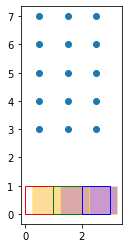

In [19]:
ax = plt.axes()
ax = simple_data.plot(
    ax=ax, color=["orange", "brown", "purple"], edgecolor="yellow", alpha=0.4
)
ax = simple_aoi.plot(ax=ax, facecolor="none", edgecolor=["r", "g", "b"])
ax = simple_point_data.plot(ax=ax)

The red,green,blue outlines are the 3 regions of interest (aoi) while the orange,brown, purple areas are the data areas. 

In [20]:
%%time
results = create_distance_zonal_stats(
    simple_aoi,
    simple_point_data,
    max_distance=7,
    aggregations=[
        dict(func="count"),
        dict(func="sum", column="population"),
        dict(func="mean", column="internet_speed"),
    ],
)

CPU times: user 36 ms, sys: 3.39 ms, total: 39.4 ms
Wall time: 33.5 ms


In [21]:
results

,geometry,index_count,population_sum,internet_speed_mean,nearest
0,"POLYGON ((0.000 0.000, 0.000 1.000, 1.000 1.00...",1,100,20.0,2.0
1,"POLYGON ((1.000 0.000, 1.000 1.000, 2.000 1.00...",1,200,10.0,2.0
2,"POLYGON ((2.000 0.000, 2.000 1.000, 3.000 1.00...",1,300,5.0,2.0


In [22]:
%%time
results2 = create_distance_zonal_stats(
    simple_aoi,
    simple_data,
    max_distance=1,
    aggregations=[
        dict(func="count"),
        dict(func="sum", column="population"),
        dict(func="mean", column="internet_speed"),
    ],
)

CPU times: user 30.2 ms, sys: 9.79 ms, total: 40 ms
Wall time: 34.4 ms


In [23]:
results2

,geometry,index_count,population_sum,internet_speed_mean,nearest
0,"POLYGON ((0.000 0.000, 0.000 1.000, 1.000 1.00...",1,100,20.0,0.0
1,"POLYGON ((1.000 0.000, 1.000 1.000, 2.000 1.00...",2,300,15.0,0.0
2,"POLYGON ((2.000 0.000, 2.000 1.000, 3.000 1.00...",2,500,7.5,0.0


### Test on custom admin grids

In [24]:
%%time
region3_admin_grids = gpd.read_file("../data/region3_admin_grids.geojson")
region3_admin_grids = region3_admin_grids.to_crs("EPSG:3857")  # convert to planar

CPU times: user 68.8 ms, sys: 45.9 ms, total: 115 ms
Wall time: 102 ms


In [25]:
%%time
region34ncr_osm_pois = gpd.read_file("../data/region34ncr_osm_pois.geojson")
region34ncr_osm_pois = region34ncr_osm_pois.to_crs("EPSG:3857")

CPU times: user 111 ms, sys: 0 ns, total: 111 ms
Wall time: 110 ms


In [26]:
region34ncr_osm_pois

,osm_id,code,fclass,name,BARANGAY_CODE,geometry
0,311568428,2701,tourist_info,Manila American Cemetery and Memorial Visitor ...,137602022,POINT (13475059.129 1636701.151)
1,672565496,2701,tourist_info,ecopark paging and first aid station,137404141,POINT (13477983.748 1656000.058)
2,672565498,2701,tourist_info,Ecopark ticket counter,137404141,POINT (13477813.318 1656135.868)
3,1585389544,2701,tourist_info,Area Formerly Occupied by Fort Bonifacio Museum,137602021,POINT (13476156.594 1637474.593)
4,1834855424,2701,tourist_info,Lotto Booth,137601020,POINT (13468786.053 1622805.175)
...,...,...,...,...,...,...
2829,1282790636,2723,monument,Rizal Monument,030808004,POINT (13387876.843 1652143.344)
2830,1430752967,2723,monument,Rizal Monument,034903092,POINT (13464327.852 1743609.163)
2831,2280492117,2723,monument,Rizal Monument,031421037,POINT (13467118.142 1705384.453)
2832,4898774223,2723,monument,Rizal Monument,035414009,POINT (13434387.128 1685457.796)


In [27]:
%%time
results3 = create_distance_zonal_stats(
    region3_admin_grids,
    region34ncr_osm_pois,
    max_distance=10_000,
    aggregations=[dict(func="count", output="pois_count", fillna=[True])],
)

CPU times: user 59.7 ms, sys: 0 ns, total: 59.7 ms
Wall time: 57.5 ms


In [28]:
len(results3[results3.pois_count == 0.0])

165

In [29]:
results3

,x,y,geometry,pois_count,nearest
0,0,30,"POLYGON ((13334497.956 1771012.807, 13339497.9...",1.0,8849.591855
1,0,31,"POLYGON ((13334497.956 1776012.807, 13339497.9...",1.0,8844.448848
2,0,32,"POLYGON ((13334497.956 1781012.807, 13339497.9...",0.0,NaN
3,1,30,"POLYGON ((13339497.956 1771012.807, 13344497.9...",1.0,3856.266007
4,1,32,"POLYGON ((13339497.956 1781012.807, 13344497.9...",1.0,6070.762498
...,...,...,...,...,...
1069,54,44,"POLYGON ((13604497.956 1841012.807, 13609497.9...",1.0,674.134053
1070,54,45,"POLYGON ((13604497.956 1846012.807, 13609497.9...",2.0,0.000000
1071,54,46,"POLYGON ((13604497.956 1851012.807, 13609497.9...",1.0,4237.158313
1072,54,47,"POLYGON ((13604497.956 1856012.807, 13609497.9...",1.0,9237.158313
